In [1]:
import emlp
from emlp.datasets import Inertia
from emlp.groups import SO
from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import objax
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [2]:
trainset = Inertia(500)  # Initialize dataset with 500 examples
testset = Inertia(250)
G = SO(3)
print(f"Input type: {trainset.rep_in(G)}, output type: {trainset.rep_out(G)}")

Input type: 5V⁰+5V, output type: V²


In [3]:
model = emlp.nn.EMLP(
    trainset.rep_in,
    trainset.rep_out,
    group=G,
    num_layers=3,
    ch=384,
)

In [4]:
BS = 25
lr = 3e-3
NUM_EPOCHS = 100

opt = objax.optimizer.Adam(model.vars())


@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    return ((yhat - y) ** 2).mean()


grad_and_val = objax.GradValues(loss, model.vars())


@objax.Jit
@objax.Function.with_vars(model.vars() + opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v


trainloader = DataLoader(trainset, batch_size=BS, shuffle=True)
testloader = DataLoader(testset, batch_size=BS, shuffle=True)

In [5]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(
        np.mean(
            [
                train_op(jnp.array(x), jnp.array(y), lr)
                for (x, y) in trainloader
            ]
        )
    )
    if not epoch % 10:
        test_losses.append(
            np.mean(
                [loss(jnp.array(x), jnp.array(y)) for (x, y) in testloader]
            )
        )

  0%|          | 0/100 [00:00<?, ?it/s]

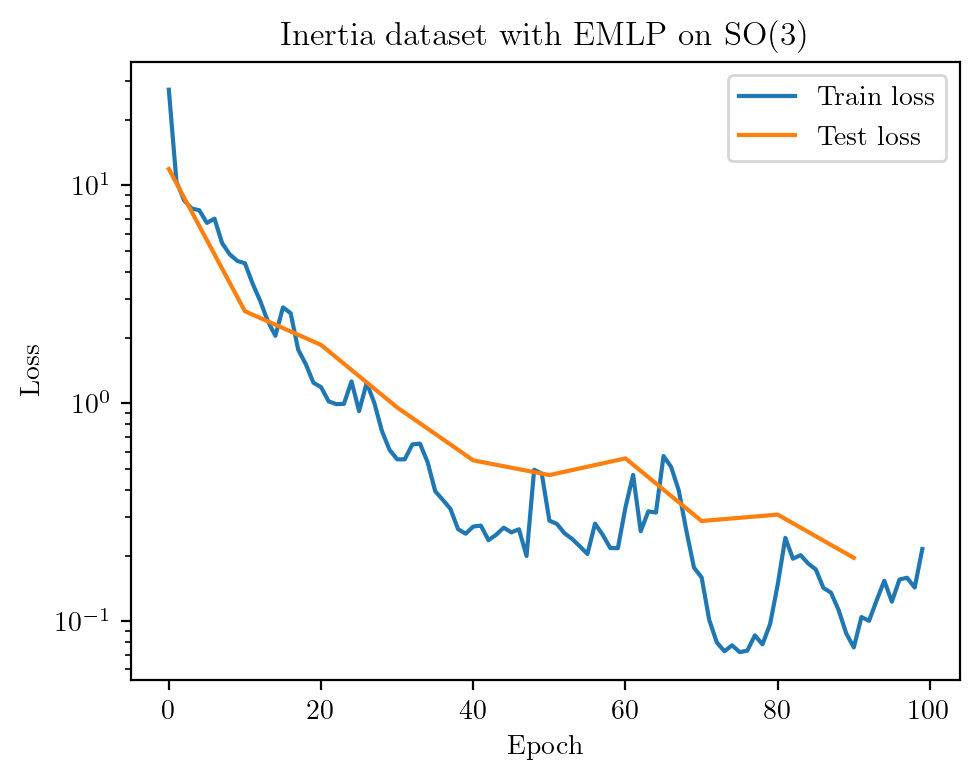

In [6]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
width = 5
height = 4
fig, ax = plt.subplots()
fig.set_size_inches(width, height)  # exact size of the figure
fig.set_dpi(200)

ax.plot(np.arange(NUM_EPOCHS), train_losses, label="Train loss")
ax.plot(
    np.arange(0, NUM_EPOCHS, 10),
    test_losses,
    label="Test loss",
)
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Inertia dataset with EMLP on SO(3)")
plt.tight_layout()
plt.show()

In [7]:
def rel_err(a, b):
    return jnp.sqrt(((a - b) ** 2).mean()) / (
        jnp.sqrt((a**2).mean()) + jnp.sqrt((b**2).mean())
    )  #


rin, rout = trainset.rep_in(G), trainset.rep_out(G)


def equivariance_err(mb):
    x, y = mb
    x, y = jnp.array(x), jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin @ x[..., None])[..., 0], training=False)
    y2 = (rho_gout @ model(x, training=False)[..., None])[..., 0]
    return rel_err(y1, y2)

In [8]:
eq_err = np.mean([equivariance_err(mb) for mb in testloader])

print(f"Average test equivariance error {eq_err:.2e}")

Average test equivariance error 3.64e-07


In [9]:
model = emlp.nn.MLP(
    trainset.rep_in,
    trainset.rep_out,
    group=G,
    num_layers=3,
    ch=384,
)

In [10]:
opt = objax.optimizer.Adam(model.vars())


@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    return ((yhat - y) ** 2).mean()


grad_and_val = objax.GradValues(loss, model.vars())


@objax.Jit
@objax.Function.with_vars(model.vars() + opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v


trainloader = DataLoader(trainset, batch_size=BS, shuffle=True)
testloader = DataLoader(testset, batch_size=BS, shuffle=True)

In [11]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(
        np.mean(
            [
                train_op(jnp.array(x), jnp.array(y), lr)
                for (x, y) in trainloader
            ]
        )
    )
    if not epoch % 10:
        test_losses.append(
            np.mean(
                [loss(jnp.array(x), jnp.array(y)) for (x, y) in testloader]
            )
        )

  0%|          | 0/100 [00:00<?, ?it/s]

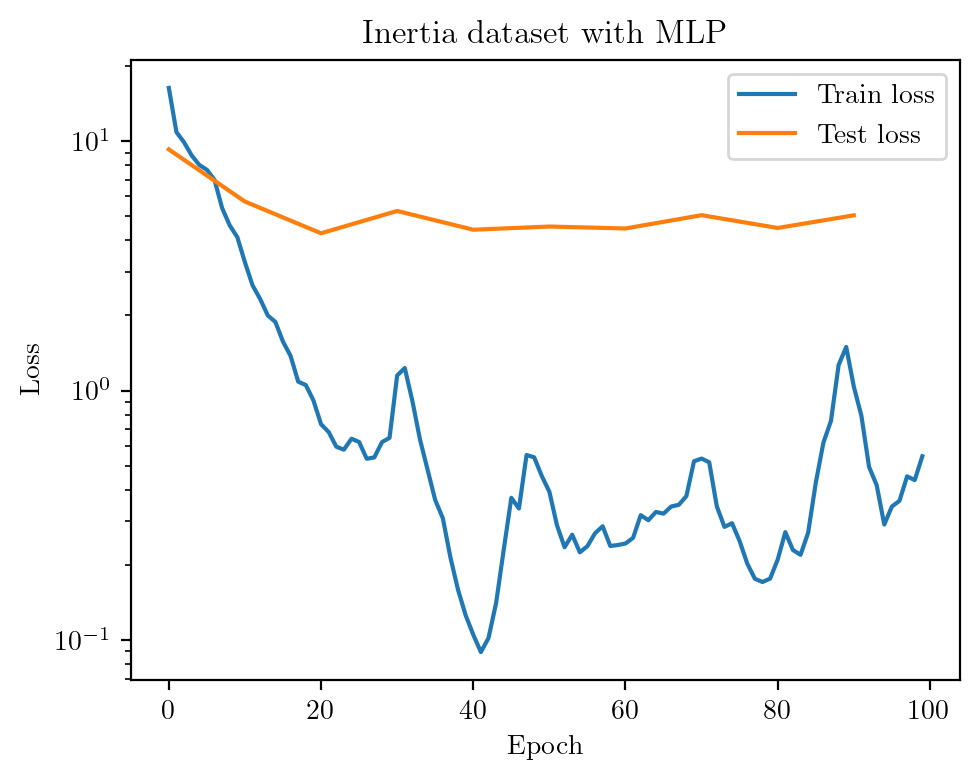

In [12]:
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
width = 5
height = 4
fig, ax = plt.subplots()
fig.set_size_inches(width, height)  # exact size of the figure
fig.set_dpi(200)

ax.plot(np.arange(NUM_EPOCHS), train_losses, label="Train loss")
ax.plot(
    np.arange(0, NUM_EPOCHS, 10),
    test_losses,
    label="Test loss",
)
ax.legend()
ax.set_yscale("log")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Inertia dataset with MLP")
plt.tight_layout()
plt.show()

In [13]:
eq_err = np.mean([equivariance_err(mb) for mb in testloader])

print(f"Average test equivariance error {eq_err:.2e}")

Average test equivariance error 1.59e-01
